In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import models
from keras import layers
from keras import callbacks
from keras.preprocessing.text import Tokenizer  
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
import pickle

In [2]:
#For google colab we mount google drive 
from google.colab import drive 
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
tweets_data_path = "/content/drive/MyDrive/preprocessed_tweets.csv"

In [4]:
df = pd.read_csv(tweets_data_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    458197 non-null  int64 
 1   Unnamed: 0.1  458197 non-null  int64 
 2   id            458197 non-null  int64 
 3   dialect       458197 non-null  int64 
 4   tweets        457992 non-null  object
dtypes: int64(4), object(1)
memory usage: 17.5+ MB


In [6]:
features = df.tweets.values.astype(str)
lables = pd.get_dummies(df['dialect']).values #One-hot encoding the lables

In [11]:
# Fit the tokenizer
# Either pre-define vocab size
# Or get the max possible vocab from text
import nltk
nltk.download('punkt')
vocab_sz = 1500 # None means all
vectorizer = TfidfVectorizer(max_features = vocab_sz, tokenizer=word_tokenize, analyzer='word')
vectorizer.fit(features)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=1500,
                tokenizer=<function word_tokenize at 0x7f1550719560>)

In [12]:
len(vectorizer.vocabulary_)

1500

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, lables, random_state=42, test_size=0.1, shuffle=True)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)

In [15]:
y_train.shape, y_val.shape, y_test.shape

((371139, 18), (41238, 18), (45820, 18))

In [16]:
X_train.shape, X_val.shape, X_test.shape

((371139,), (41238,), (45820,))

In [ ]:
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    vectorizer = pickle.load(handle)
vocab_sz = 1500

In [17]:
# Extract binary BoW features
x_train = vectorizer.transform(X_train).toarray()

In [18]:
x_val = vectorizer.transform(X_val).toarray()

In [19]:
x_test = vectorizer.transform(X_test).toarray()

In [20]:
X_train[1]

'محتاج تغير مش محتاج دافع او كفيل يغيرك انت محتاج انك تغير فكره انك عمرك هتغير الموضوع سهل جدا محتاج لفكره فكرهتغيرسلبياتك'

In [21]:
x_train[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(vocab_sz,)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(18, activation='softmax'))

In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
callback = callbacks.EarlyStopping(monitor='loss', patience=3)

In [25]:
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/100
725/725 [==============================] - 14s 18ms/step - loss: 2.6155 - accuracy: 0.1837 - val_loss: 2.3583 - val_accuracy: 0.2530
Epoch 2/100
725/725 [==============================] - 13s 17ms/step - loss: 2.4072 - accuracy: 0.2428 - val_loss: 2.2818 - val_accuracy: 0.2740
Epoch 3/100
725/725 [==============================] - 13s 18ms/step - loss: 2.3570 - accuracy: 0.2577 - val_loss: 2.2513 - val_accuracy: 0.2792
Epoch 4/100
725/725 [==============================] - 13s 17ms/step - loss: 2.3318 - accuracy: 0.2651 - val_loss: 2.2241 - val_accuracy: 0.2875
Epoch 5/100
725/725 [==============================] - 13s 17ms/step - loss: 2.3114 - accuracy: 0.2723 - val_loss: 2.2022 - val_accuracy: 0.3003
Epoch 6/100
725/725 [==============================] - 13s 18ms/step - loss: 2.2978 - accuracy: 0.2785 - val_loss: 2.1889 - val_accuracy: 0.3045
Epoch 7/100
725/725 [==============================] - 13s 18ms/step - loss: 2.2862 - accuracy: 0.2818 - val_loss: 2.1792 - val_ac

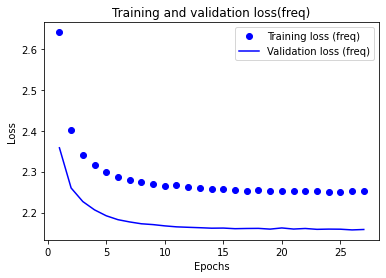

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss (freq)')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss (freq)')
plt.title('Training and validation loss(freq)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

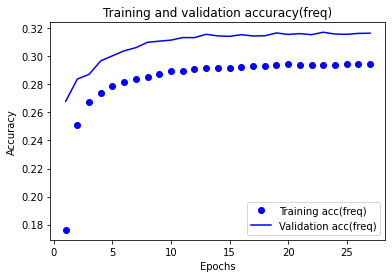

In [ ]:
plt.clf()   # clear figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc(freq)')
plt.plot(epochs, val_acc, 'b', label='Validation acc(freq)')
plt.title('Training and validation accuracy(freq)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Saving tokenizer and the model**

In [26]:
import pickle

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving deep learning model
model.save('dense_model.h5')

In [27]:
!cp dense_model.h5 /content/drive/MyDrive/

In [28]:
!cp tokenizer.pickle /content/drive/MyDrive/

# Testing the model

**Evaluating the model on the test data**

In [37]:
prediction_load = model.evaluate(x_test,y_test)

1432/1432 [==============================] - 5s 3ms/step - loss: 2.1538 - accuracy: 0.3118


**Model inference**

In [55]:
def dense_nn_inference(text):
    '''
    Individual testing of the model given a text.
    '''
    class_dict = {0:"AE",1:"BH",2:"DZ",3:"EG",4:"IQ",5:"JO",6:"KW",7:"LB",8:"LY",9:"MA",
                  10:"OM",11:"PL",12:"QA",13:"SA",14:"SD",15:"SY",16:"TN",17:"YE"}
    # loading tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    # loading dense model
    loaded_model = models.load_model("dense_model.h5")
    tokenized_load = tokenizer.transform([text]).toarray()
    prediction_load = loaded_model.predict(tokenized_load)
    return class_dict[np.argmax(prediction_load)]
        

In [57]:
dense_nn_inference("اللي بتقولوه دا مش هينفع")

'EG'

In [56]:
dense_nn_inference("شلونك شو تسوي")

'KW'